In [1]:
import pandas as pd

In [2]:
#messages = pd.read_csv('/content/spam.csv',header=None,sep='^([^;]+);', engine='python', usecols=['label', 'msg'])
messages = pd.read_csv('/content/spam.csv',sep = ';',names= ['label', 'message'],header=None)

In [3]:
messages.head()
msg=messages.iloc[0,1]
print(len(messages.index))
print(msg)


5574
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


In [4]:
messages.groupby('label').describe()
messages['length'] = messages['message'].apply(len)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d0e766650>,
      dtype=object)

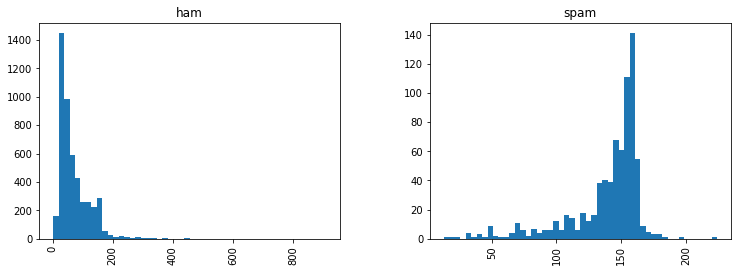

In [5]:
messages.head()
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

** Baseline - Feature Extraction v1** 

mensagens do tipo spam costumam ser mais longas que as mensagens do tipo ham

In [6]:
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
#reference - https://www.kaggle.com/ranjitmishra/sms-spam-collection-natural-language-processing
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [8]:
# Check to make sure its working
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

11425


In [11]:
messages_bow = bow_transformer.transform(messages['message'])
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

Shape of Sparse Matrix:  (5574, 11425)
Amount of Non-Zero occurences:  50547
sparsity: 0


TF-IDF - term frequency-inverse document frequency

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

DF(t) = log_e(Total number of documents / Number of documents with term t in it).

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5574, 11425)


In [13]:
print(type(messages_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


In [14]:
#Save the data
from scipy import sparse
sparse.save_npz('/content/data_sparse.npz', messages_tfidf)



Load classification libs

In [15]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

Dividir o dataset na taxa 80-20% de maneira estratificada

Aviso: como há poucos dados do tipo spam, o random_state o tamanho do subconjunto de dados alteram o resultado. 

Como no paper original não foi publicado a significância dos testes, qualquer resultado que se encontra entre o mínimo e máximo apresentados pelo paper são aceitáveis. 


In [19]:
train, test, train_labels, test_labels = train_test_split(messages_tfidf, messages['label'], 
                                                                    random_state=25, 
                                                                    test_size=0.2, 
                                                                    stratify=messages['label'])

Análise de resultados de validação cruzada estratificada sem considerar o desbalanceamento

In [20]:
# define model without considering imbalance
model = XGBClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, train, train_labels, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.95280


Análise de resultados de validação cruzada estratificada considerando o desbalanceamento

In [18]:
# define model
modelw = XGBClassifier(scale_pos_weight=6.46)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(modelw,train, train_labels, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.95827


Busca aproximada por hiperparâmetro de desbalanceamento.

Aviso: o método de gridsearch foi escolhido devido ao tempo de prova, pois há métodos muito mais eficientes.

Não evidência que o ajuste de parâmetro apresente melhora significativa no método escolhido. Desta forma, a maneira ideal é aumentar a quantidade de dados ao invés de definir métodos de escolha de hiperparâmetros.

In [21]:
from sklearn.model_selection import GridSearchCV
model = XGBClassifier()
# define grid
weights = [1, 3, 5, 6, 7, 9, 10, 15]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(train, train_labels)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.958023 using {'scale_pos_weight': 15}
0.952801 (0.016829) with: {'scale_pos_weight': 1}
0.953403 (0.018214) with: {'scale_pos_weight': 3}
0.954635 (0.017108) with: {'scale_pos_weight': 5}
0.955775 (0.016712) with: {'scale_pos_weight': 6}
0.955350 (0.017167) with: {'scale_pos_weight': 7}
0.955217 (0.016700) with: {'scale_pos_weight': 9}
0.956144 (0.016466) with: {'scale_pos_weight': 10}
0.958023 (0.015852) with: {'scale_pos_weight': 15}


Treinar modelo com melhor parâmetro e salvar com pickle

Foi escolhido o parâmetro de proporção aproximada entre classes

In [26]:
from sklearn.externals import joblib
print(grid_result.best_params_)
modelf = XGBClassifier(scale_pos_weight= 6)

modelf.fit(train, train_labels)
joblib.dump(modelf, '/content/model_xgboost.pkl')

{'scale_pos_weight': 15}


['/content/model_xgboost.pkl']

Carregar modelo e avaliar no conjunto de teste

In [27]:
#Inference on test set
xgboostv1 = joblib.load('/content/model_xgboost.pkl')
 
pred=xgboostv1.predict(test)


Métricas - TN, TP, FP, FN, Matthews Correlation 

Análise: Maior número possível de TN e TP

FP - Gera alerta (bloqueia mensagem), logo é necessário reenviar em casos que não são spam ou ham

FN - Não gera alerta (não bloqueia mensagem que deveria ser bloqueado). Caso crítico. 

Matthews Correlation - Comparação com paper

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

tn, fp, fn, tp =confusion_matrix(test_labels, pred).ravel()
pred_m=matthews_corrcoef(test_labels, pred)
accuracy=accuracy_score(test_labels, pred)

In [31]:
print(tn)
print(fp)
print(fn)
print(tp)
print(pred_m)
print(accuracy)

950
16
20
129
0.8590654365863765
0.967713004484305
